# Sequence of updates in EBMR with product of normals

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

### About

Here, I am simply checking whether the sequence of updates has any effect on the optimization in the variational approximation of EBMR. Earlier, I found that the variational approximation for the product of two normals leads to severe overfitting ([see here](https://banskt.github.io/iridge-notes/jupyter/2020/12/30/ebmr-with-product-of-coefficients.html#Variational-approximation)).

In [1]:
#collapse

import numpy as np
import pandas as pd
from scipy import linalg as sc_linalg
import matplotlib.pyplot as plt

import sys
sys.path.append("../../ebmrPy/")
from inference.ebmr import EBMR
from inference import f_elbo
from inference import f_sigma
from inference import penalized_em
from utils import log_density

sys.path.append("../../utils/")
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

### Toy example

The same trend-filtering data as used previously.

In [2]:
#collapse

def standardize(X):
    Xnorm = (X - np.mean(X, axis = 0)) 
    #Xstd =  Xnorm / np.std(Xnorm, axis = 0)
    Xstd = Xnorm / np.sqrt((Xnorm * Xnorm).sum(axis = 0))
    return Xstd

def trend_data(n, p, bval = 1.0, sd = 1.0, seed=100):
    np.random.seed(seed)
    X = np.zeros((n, p))
    for i in range(p):
        X[i:n, i] = np.arange(1, n - i + 1)
    btrue = np.zeros(p)
    idx = int(n / 3)
    btrue[idx] = bval
    btrue[idx + 1] = -bval
    y = np.dot(X, btrue) + np.random.normal(0, sd, n)
    # y = y / np.std(y)
    return X, y, btrue

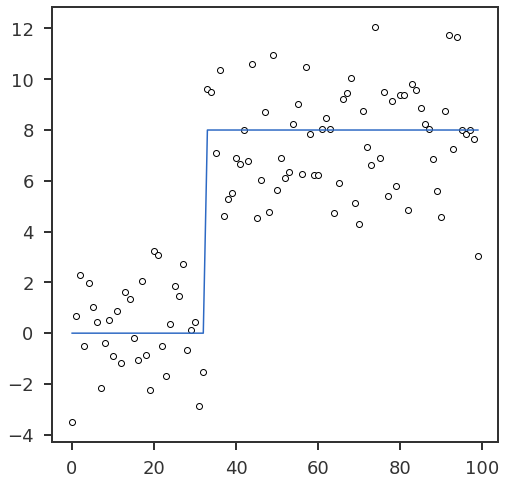

In [3]:
#collapse-show

n = 100
p = 200
bval = 8.0
sd = 2.0
X, y, btrue = trend_data(n, p, bval = bval, sd = sd)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(n), np.dot(X, btrue))
ax1.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
plt.show()

### Sequence 1

Here, I am updating $\mathbf{S}$, $\mathbf{m}$, $\sigma^2$, $\sigma_b^2$, $\{v_j^2\}$, $\{a_j\}$ and $\sigma_w^2$ in that order.

In [4]:
#collapse-hide

def ridge_mll(X, y, s2, sb2, W):
    n, p = X.shape
    Xscale = np.dot(X, np.diag(W))
    XWWtXt = np.dot(Xscale, Xscale.T)
    sigmay = s2 * (np.eye(n) + sb2 * XWWtXt)
    muy    = np.zeros((n, 1))
    return log_density.mgauss(y.reshape(-1,1), muy, sigmay)

def grr_b(X, y, s2, sb2, Wbar, varWj, XTX, XTy):
    n, p = X.shape
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    VW = np.diag(XTX) * varWj
    
    sigmabinv = (WtXtXW + np.diag(VW) + np.eye(p) * s2 / sb2) / s2
    sigmab = np.linalg.inv(sigmabinv)
    mub = np.linalg.multi_dot([sigmab, W.T, XTy]) / s2
    
    XWmu = np.linalg.multi_dot([X, W, mub])
    mub2 = np.square(mub)
    s2 = (np.sum(np.square(y - XWmu)) \
          + np.dot((WtXtXW + np.diag(VW)), sigmab).trace() \
          + np.sum(mub2 * VW)) / n
    sb2 = (np.sum(mub2) + sigmab.trace()) / p
    return s2, sb2, mub, sigmab

def grr_W_old(X, y, s2, sw2, mub, sigmab, muWj, XTX, XTy):
    n, p = X.shape
    R = np.einsum('i,j->ij', mub, mub) + sigmab
    XTXRjj = np.array([XTX[j, j] * R[j, j] for j in range(p)])
    #wXTXRj = np.array([np.sum(muWj * XTX[:, j] * R[:, j]) - (muWj[j] * XTXRjj[j]) for j in range(p)])
    sigmaWj2 = 1 / ((XTXRjj / s2) + (1 / sw2))
    for j in range(p):
        wXTXRj = np.sum(muWj * XTX[:, j] * R[:, j]) - (muWj[j] * XTXRjj[j])
        muWj[j] = sigmaWj2[j] * (mub[j] * XTy[j] - 0.5 * wXTXRj) / s2
    sw2 = np.sum(np.square(muWj) + sigmaWj2) / p
    return sw2, muWj, sigmaWj2


def grr_W(X, y, s2, sw2, mub, sigmab, muWj, XTX, XTy):
    n, p = X.shape
    R = np.einsum('i,j->ij', mub, mub) + sigmab
    XTXRjj = np.diag(XTX) * np.diag(R)
    sigmaWj2inv = (XTXRjj / s2) + (1 / sw2)
    wXTXRj = np.array([np.sum(muWj * XTX[:, j] * R[:, j]) - (muWj[j] * XTXRjj[j]) for j in range(p)])
    sigmaWj2 = 1 / sigmaWj2inv
    muWj = sigmaWj2 * (mub * XTy - wXTXRj) / s2
    sw2 = np.sum(np.square(muWj) + sigmaWj2) / p
    #sigmaWj2 = np.zeros(p)
    return sw2, muWj, sigmaWj2
        

def elbo(X, y, s2, sb2, sw2, mub, sigmab, Wbar, varWj, XTX):
    '''
    Wbar is a vector which contains the diagonal elements of the diagonal matrix W
    W = diag_matrix(Wbar)
    Wbar = diag(W)
    --
    VW is a vector which contains the diagonal elements of the diagonal matrix V_w
    '''
    n, p = X.shape
    VW = np.diag(XTX) * varWj
    elbo = c_func(n, p, s2, sb2, sw2) \
           + h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW) \
           + h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varWj, VW)
    return elbo


def c_func(n, p, s2, sb2, sw2):
    val  =   p
    val += - 0.5 * n * np.log(2.0 * np.pi * s2)
    val += - 0.5 * p * np.log(sb2)
    val += - 0.5 * p * np.log(sw2)
    return val


def h1_func(X, y, s2, sb2, sw2, mub, Wbar, VW):
    XWmu = np.linalg.multi_dot([X, np.diag(Wbar), mub])
    val1 = - (0.5 / s2) * np.sum(np.square(y - XWmu))
    val2 = - 0.5 * np.sum(np.square(mub) * ((VW / s2) + (1 / sb2)))
    val3 = - 0.5 * np.sum(np.square(Wbar)) / sw2
    val  = val1 + val2 + val3
    return val


def h2_func(p, s2, sb2, sw2, XTX, Wbar, sigmab, varWj, VW):
    (sign, logdetS) = np.linalg.slogdet(sigmab)
    logdetV = np.sum(np.log(varWj))
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    val  =   0.5 * logdetS + 0.5 * logdetV
    val += - 0.5 * np.trace(sigmab) / sb2 - 0.5 * np.sum(varWj) / sw2
    val += - 0.5 * np.dot(WtXtXW + np.diag(VW), sigmab).trace() / s2
    return val
    

def ebmr_WB1(X, y,
            s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
            binit = None, winit = None,
            max_iter = 1000, tol = 1e-8
           ):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    n_samples, n_features = X.shape
    elbo_path = np.zeros(max_iter + 1)
    mll_path = np.zeros(max_iter + 1)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    sw2 = sw2_init
    mub = np.ones(n_features)  if binit is None else binit
    muWj = np.ones(n_features) if winit is None else winit
    sigmab = np.zeros((n_features, n_features))
    sigmaWj2 = np.zeros(n_features)
    elbo_path[0] = -np.inf
    mll_path[0] = -np.inf
    
    for itn in range(1, max_iter + 1):
        '''
        GRR for b
        '''
        s2, sb2, mub, sigmab = grr_b(X, y, s2, sb2, muWj, sigmaWj2, XTX, XTy)
        
        '''
        GRR for W
        '''
        sw2, muWj, sigmaWj2  = grr_W(X, y, s2, sw2, mub, sigmab, muWj, XTX, XTy)
        
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = elbo(X, y, s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, XTX)
        mll_path[itn] = ridge_mll(X, y, s2, sb2, muWj)
        if elbo_path[itn] - elbo_path[itn - 1] < tol: break
        #if mll_path[itn] - mll_path[itn - 1] < tol: break
    return s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, niter, elbo_path[:niter + 1], mll_path[:niter + 1]

And this leads to overfitting as we have seen previously.

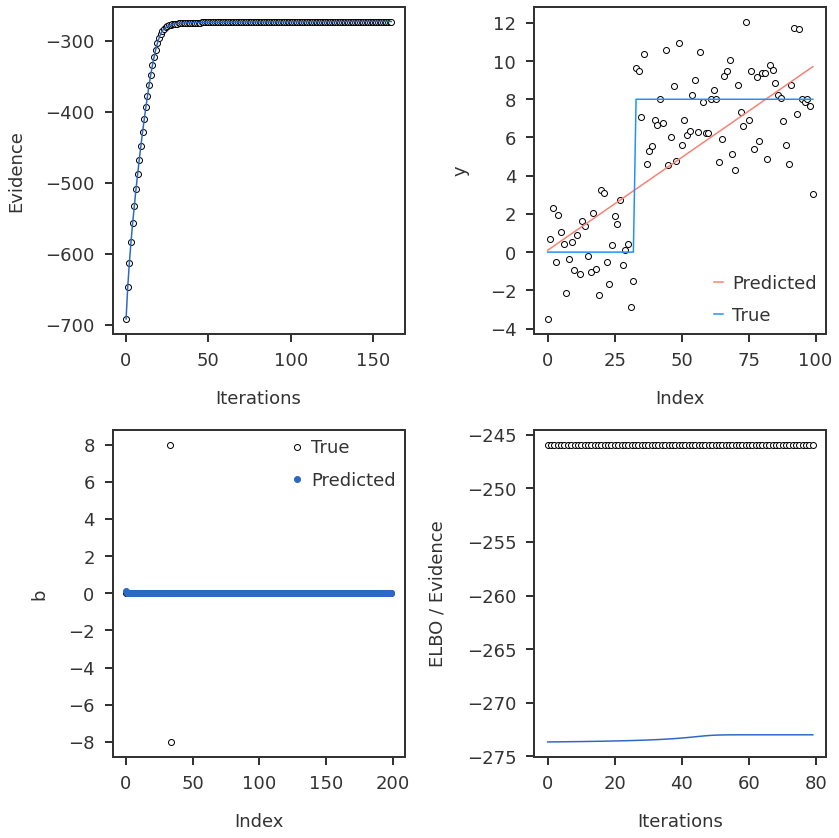

In [5]:
#collapse-hide
m1 = ebmr_WB1(X, y)

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m1
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.arange(niter-1), elbo_path[2:], edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter-1), elbo_path[2:])
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Evidence")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Index")
ax3.set_ylabel("b")

nstep = min(80, niter - 2)
ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white')
ax4.plot(np.arange(nstep), elbo_path[-nstep:])
ax4.set_xlabel("Iterations")
ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()

### Sequence 2

Here, I am updating $\mathbf{S}$, $\mathbf{m}$, $\{v_j^2\}$, $\{a_j\}$, $\sigma^2$, $\sigma_b^2$ and $\sigma_w^2$ in that order.

In [6]:
def update_qbw(X, s2, sb2, sw2, mub, sigmab, Wbar, varWj, XTX, XTy):
    n, p = X.shape
    W = np.diag(Wbar)
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    VW = np.diag(XTX) * varWj
    
    # update mub and sigmab
    sigmabinv = (WtXtXW + np.diag(VW) + np.eye(p) * s2 / sb2) / s2
    sigmab = np.linalg.inv(sigmabinv)
    mub = np.linalg.multi_dot([sigmab, W.T, XTy]) / s2
    
    # update Wbar and varWj
    R = np.einsum('i,j->ij', mub, mub) + sigmab
    XTXRjj = np.diag(XTX) * np.diag(R)
    wXTXRj = np.array([np.sum(Wbar * XTX[:, j] * R[:, j]) - (Wbar[j] * XTXRjj[j]) for j in range(p)])
    varWjinv = (XTXRjj / s2) + (1 / sw2)
    varWj = 1 / varWjinv    
    for j in range(p):
        wXTXRj = np.sum(Wbar * XTX[:, j] * R[:, j]) - (Wbar[j] * XTXRjj[j])
        Wbar[j] = varWj[j] * (mub[j] * XTy[j] - wXTXRj) / s2
    #Wbar = varWj * (mub * XTy - wXTXRj) / s2

    return mub, sigmab, Wbar, varWj


def update_params(X, y, mub, sigmab, Wbar, varWj, XTX):
    n, p = X.shape
    W = np.diag(Wbar)
    VW = np.diag(XTX) * varWj
    WtXtXW = np.linalg.multi_dot([W.T, XTX, W])
    XWmu = np.linalg.multi_dot([X, W, mub])
    mub2 = np.square(mub)
    # update the parameters
    s2 = (np.sum(np.square(y - XWmu)) \
          + np.dot((WtXtXW + np.diag(VW)), sigmab).trace() \
          + np.sum(mub2 * VW)) / n
    sb2 = np.sum(np.square(mub)  + np.diag(sigmab)) / p
    sw2 = np.sum(np.square(Wbar) + varWj) / p
    return s2, sb2, sw2


def ebmr_WB2(X, y,
            s2_init = 1.0, sb2_init = 1.0, sw2_init = 1.0,
            binit = None, winit = None,
            max_iter = 1000, tol = 1e-8
           ):
    XTX = np.dot(X.T, X)
    XTy = np.dot(X.T, y)
    n_samples, n_features = X.shape
    elbo_path = np.zeros(max_iter + 1)
    mll_path = np.zeros(max_iter + 1)
    
    '''
    Iteration 0
    '''
    niter = 0
    s2 = s2_init
    sb2 = sb2_init
    sw2 = sw2_init
    mub = np.ones(n_features)  if binit is None else binit
    muWj = np.ones(n_features) if winit is None else winit
    sigmab = np.zeros((n_features, n_features))
    sigmaWj2 = np.zeros(n_features)
    elbo_path[0] = -np.inf
    mll_path[0] = -np.inf
    
    for itn in range(1, max_iter + 1):
        '''
        Update q(b, w)
        '''
        mub, sigmab, muWj, sigmaWj2 = update_qbw(X, s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, XTX, XTy)
        
        '''
        Update s2, sb2, sw2
        '''
        s2, sb2, sw2 = update_params(X, y, mub, sigmab, muWj, sigmaWj2, XTX)
        
        '''
        Convergence
        '''
        niter += 1
        elbo_path[itn] = elbo(X, y, s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, XTX)
        mll_path[itn] = ridge_mll(X, y, s2, sb2, muWj)
        if elbo_path[itn] - elbo_path[itn - 1] < tol: break
        #if mll_path[itn] - mll_path[itn - 1] < tol: break
    return s2, sb2, sw2, mub, sigmab, muWj, sigmaWj2, niter, elbo_path[:niter + 1], mll_path[:niter + 1]

However, there is still an overfitting.

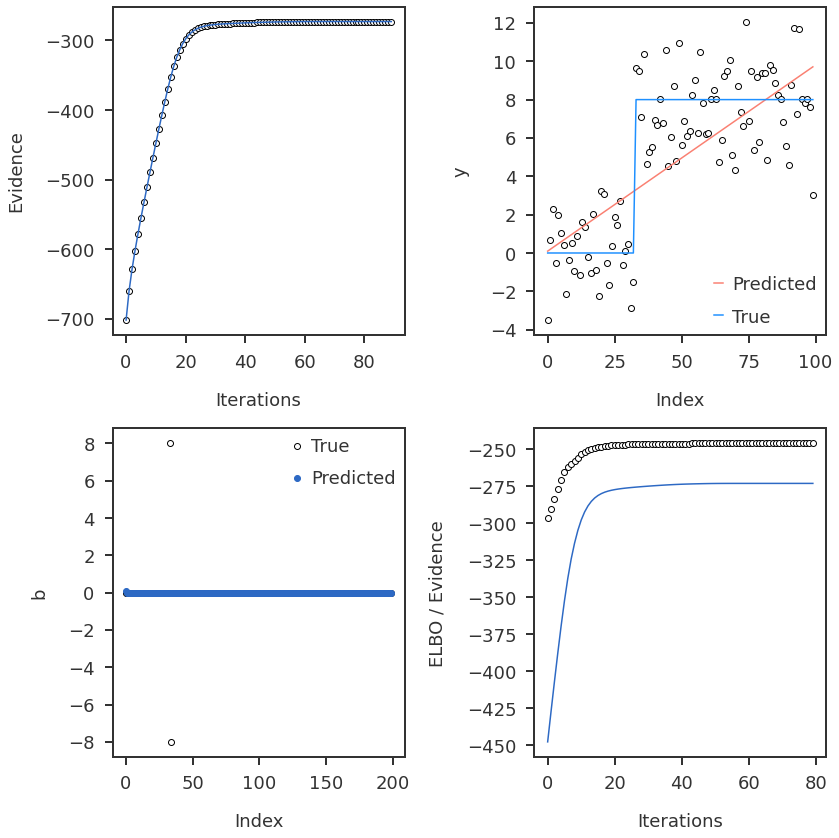

In [7]:
#collapse-hide
m2 = ebmr_WB2(X, y)

s2, sb2, sw2, mub, sigmab, W, sigmaW, niter, elbo_path, mll_path = m2
bpred = mub * W
ypred = np.dot(X, bpred)


fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(np.arange(niter-1), elbo_path[2:], edgecolor = 'black', facecolor='white')
ax1.plot(np.arange(niter-1), elbo_path[2:])
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Evidence")

ax2.scatter(np.arange(n), y, edgecolor = 'black', facecolor='white')
ax2.plot(np.arange(n), ypred, color = 'salmon', label="Predicted")
ax2.plot(np.arange(n), np.dot(X, btrue), color = 'dodgerblue', label="True")
ax2.legend()
ax2.set_xlabel("Index")
ax2.set_ylabel("y")

ax3.scatter(np.arange(p), btrue, edgecolor = 'black', facecolor='white', label="True")
ax3.scatter(np.arange(p), bpred, label="Predicted")
ax3.legend()
ax3.set_xlabel("Index")
ax3.set_ylabel("b")

nstep = min(80, niter - 2)
ax4.scatter(np.arange(nstep), mll_path[-nstep:], edgecolor = 'black', facecolor='white')
ax4.plot(np.arange(nstep), elbo_path[-nstep:])
ax4.set_xlabel("Iterations")
ax4.set_ylabel("ELBO / Evidence")

plt.tight_layout()
plt.show()